In [3]:
import numpy as np
import h5py
import matplotlib.pylab as plt
import sys
import sigpy
sys.path.append('../../../src/')

# custom scripts
import mri_cs
from undersampling import radial_sampling
from helpers import calculate_metrics, get_proportion, zero_fill, create_mask

from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

plt.style.use('dark_background')
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10.0, 8.0)

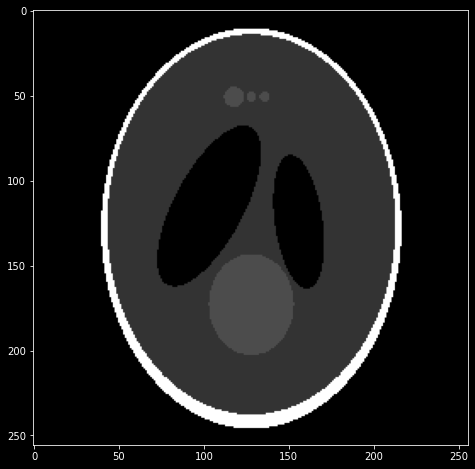

In [4]:
phantom = sigpy.shepp_logan((256, 256))
rows, cols = phantom.shape
_ = plt.imshow(np.abs(phantom), cmap="gray")

0.0791168212890625

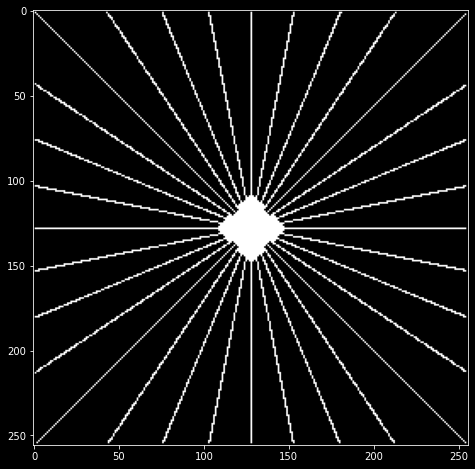

In [5]:
radial_mask = np.fft.fftshift(radial_sampling(rows, cols, 32, dilations=0))
samples_rows = np.where(radial_mask.flatten())[0]
b = np.fft.fft2(phantom).flatten()[samples_rows]

get_proportion(phantom.flatten(), b)
_ = plt.imshow(np.fft.fftshift(radial_mask))

PSNR: 19.922996530904836
SSIM: 0.30438127746616445
SNR: 6.590090835878178
MSE: 0.013424024462264846


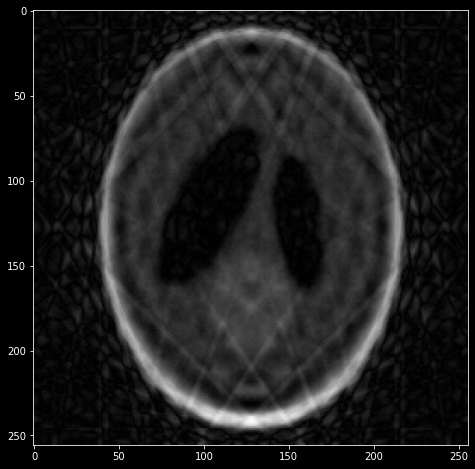

In [6]:
zero_filled = zero_fill(b, samples_rows, rows, cols)

_ = plt.imshow(np.abs(zero_filled))
_ = calculate_metrics(np.abs(phantom), np.abs(zero_filled))

# No prior information LP minimization

In [7]:
filters = [[[1.0, -1.0], [1.0, -1.0]],
            [[1.0, 1.0], [-1.0, -1.0]],
            [[1.0, -1.0], [-1.0, 1.0]]]

<module 'mri_cs' from '../../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 21.616517543792725s


PSNR: 31.776908452666895
SSIM: 0.8234194401565108
SNR: 18.147671968258766
MSE: 0.0009378310807819102


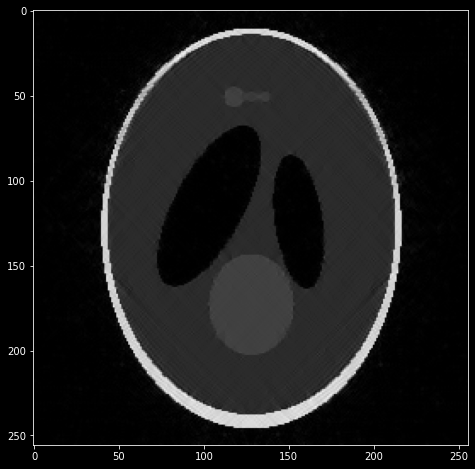

In [6]:
import mri_cs
reload(mri_cs)

rows, cols = phantom.shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30

nopi_recon = mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, 
                                 p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                 number_jobs=1, maxiterperstage=maxiterperstage,
                                 verbose=False)

plt.imshow(np.abs(nopi_recon))
_ = calculate_metrics(np.abs(phantom), np.abs(nopi_recon))

# Visualizing prior information leveraged

<module 'mri_cs' from '../../../src/mri_cs.py'>

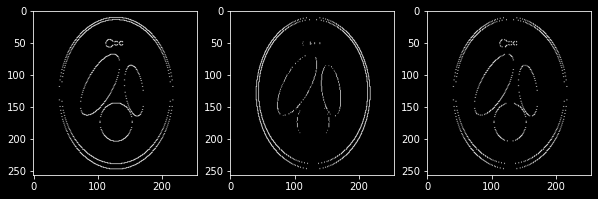

In [18]:
reload(mri_cs)
phi = mri_cs.prior_information(np.abs(phantom), pi_prop=10/100, filters=filters)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
_ = ax1.imshow(create_mask(phi[0]))
_ = ax2.imshow(create_mask(phi[1]))
_ = ax3.imshow(create_mask(phi[2]))

In [86]:
from tqdm import tqdm
def clean_labels(mask, labels):
    labels = labels.flatten()
    
    for label in tqdm(labels):
        print(np.unique(label))
        np.count_nonzero(label == label)
        
# clean_labels(mask, label_im)

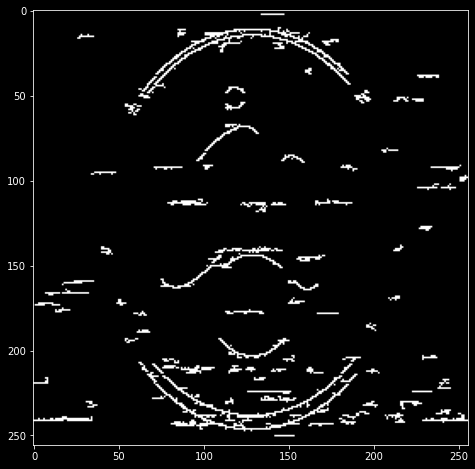

In [14]:
from scipy import ndimage
phi = mri_cs.prior_information(np.abs(phantom), pi_prop=10/100, filters=filters)

s = ndimage.generate_binary_structure(2,2)

mask = create_mask(phi[0])
mask_labels, mask_nb = ndimage.label(mask, structure=s)
mask_areas = np.array(ndimage.sum(mask, mask_labels, np.arange(mask_labels.max()+1)))
new_mask = mask_areas > 10
remove_small_mask = new_mask[mask_labels.ravel()].reshape((rows, cols))
plt.imshow(remove_small_mask)

In [89]:
sand_op = ndimage.binary_opening(mask, iterations=2)
sand_labels, sand_nb = ndimage.label(sand_op, structure=s)

sand_areas = np.array(ndimage.sum(sand_op, sand_labels, np.arange(sand_labels.max()+1)))
mask = sand_areas > 100
remove_small_sand = mask[sand_labels.ravel()].reshape(sand_labels.shape)
plt.imshow(remove_small_sand)

RuntimeError: structure and input must have equal rank

1394

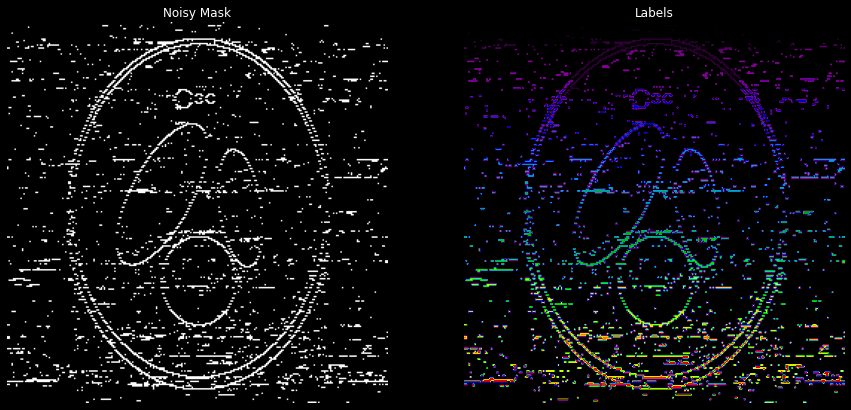

In [76]:
from scipy.ndimage import label, generate_binary_structure 

phi = mri_cs.prior_information(np.abs(phantom), pi_prop=8/100, filters=filters)

mask = create_mask(phi[0])
s = generate_binary_structure(2,2)
label_im, nb_labels = label(mask, structure=s)
nb_labels
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_figheight(12)
fig.set_figwidth(15)
_ = ax[0].imshow(mask)
_ = ax[0].set_title('Noisy Mask')
_ = ax[0].axis('off')

_ = ax[1].imshow(label_im, cmap='nipy_spectral')
_ = ax[1].set_title('Labels')
_ = ax[1].axis('off')

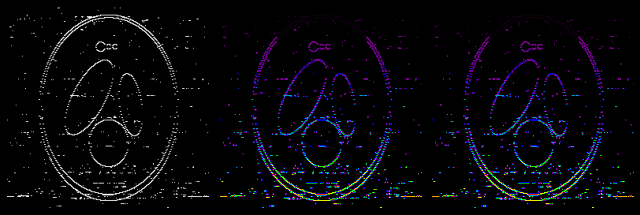

In [66]:
from skimage import measure
# from skimage import filters
import matplotlib.pyplot as plt
import numpy as np

im = create_mask(phi[0])
# im = filters.gaussian(im, sigma= l / (4. * n))
blobs = im > 0 * im.mean()

all_labels = measure.label(blobs)
blobs_labels = measure.label(blobs, background=0)

_ = plt.figure(figsize=(9, 3.5))
_ = plt.subplot(131)
_ = plt.imshow(blobs, cmap='gray')
_ = plt.axis('off')
_ = plt.subplot(132)
_ = plt.imshow(all_labels, cmap='nipy_spectral')
_ = plt.axis('off')
_ = plt.subplot(133)
_ = plt.imshow(blobs_labels, cmap='nipy_spectral')
_ = plt.axis('off')

plt.tight_layout()
plt.show()

# LP Minimization with pre filtering and prior information

<module 'mri_cs' from '../../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 18.328235387802124s
PSNR: 75.13280718177838
SSIM: 0.9999827346103897
SNR: 62.988138237434306
MSE: 3.0766492990728543e-08


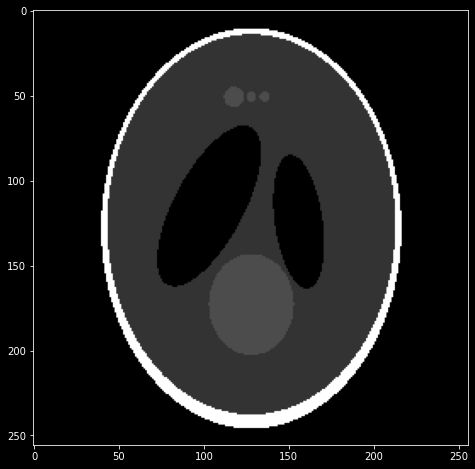

In [20]:
import mri_cs
reload(mri_cs)

rows, cols = phantom.shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30
tau = 1e-1

pi_recon = mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, 
                               p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                               number_jobs=1, maxiterperstage=maxiterperstage,
                               phi=phi, tau=tau, verbose=False)

_ = plt.imshow(np.abs(pi_recon))
_ = calculate_metrics(np.abs(phantom), np.abs(pi_recon))